# Ideal Mass-Spring system

In [1]:
# Constants
m = 1
k = 1

Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import sklearn
from torch import Tensor
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from sklearn.metrics import auc
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
from torchmetrics.regression import MeanSquaredError

/Users/martineh/Library/Caches/pypoetry/virtualenvs/harmonic-o-0uXIVf-py3.9/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Helper functions

In [3]:
## -------------------------------------------------------------------- ##
## --------------------- CREATE TRAIN DATASET ------------------------- ##
## -------------------------------------------------------------------- ##


# Gradiant of Hamiltonian
# derivative of x
def f(x):  # q, p
    # f(x) is the derivative for (q, p) with repect to time
    return np.array([1 / m * x[1], -k * x[0]])  # 1/m * p  # -k * q


# Hessian of Hamiltonian
def gradf(x):
    return np.array([-k / m * x[0], -k / m * x[1]])


# Iterativ method to minimize F
def newton_method(F, JF, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0)
    for _ in range(max_iter):
        delta = scipy.linalg.solve(JF(x), F(x))  # dx = F(x) / JF(x) -> JF(x) * dx = F(x)
        x = x - delta  # x = x - F(x) / JF(x)

        if np.linalg.norm(delta) < tol:
            return x
    raise ValueError(f"Newton's method did not converge " f"after {max_iter} iterations.")


# Forward Euler
def forwardEuler(f, x0, h):
    return x0 + h * f(x0)


# Implicit midpoint
def implicitMidpoint(f, Jf, x0, h, tol=1e-6, max_iter=1000):
    """
    Solves the implicit midpoint iteration using Newton's method for multi-dimensional case
    f        : vector-valued function defining the fixed point iteration
    Jf: Jacobian matrix of f
    x0      : initial guess (vector)
    h       : step size
    tol     : tolerance for stopping criterion
    """
    F = lambda x: x0 - x + h * f((x + x0) / 2)
    JF = lambda x: -np.eye(len(x0)) + h / 2 * Jf((x + x0) / 2)

    return newton_method(F, JF, x0, tol, max_iter)


# Add gaussian noise to signal
def gaussian_noise(x, mu, std):
    np.random.seed(42)
    noise = np.random.normal(mu, std, size=x.shape)
    x_noisy = x + noise
    return np.array(x_noisy)


## -------------------------------------------------------------------- ##
## -------------------------- TRAIN / TEST ---------------------------- ##
## -------------------------------------------------------------------- ##


def train_model(
    model,
    data_loader,
    loss_fn,
    optimizer,
    accuracy_fn,
    verbose=False,
    grad=False,
):
    """
    Training loop for 1 epoch

    Args:
        model (_type_): _description_
        data_loader (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    train_loss = 0.0  # keep track of total loss
    train_acc = 0.0  # keep track of the total accuracy

    for batch, (X_data, y_data) in enumerate(data_loader):
        # model.train()  # Set to training mode

        # Forward pass - make a prediction
        y_raw = model(X_data)  # H
        y_pred = model.postprocess(y_raw, X_data)  # H -> dqdt, dpdt

        # Compute the loss
        loss = loss_fn(y_pred, y_data)
        train_loss += loss
        acc = accuracy_fn(y_pred.detach(), y_data.detach()).detach()
        train_acc += acc

        # Compute gradient of the loss w.r.t. to the parameters
        # loss.backward()
        loss.backward(retain_graph=True)  # FIXME: Try this

        # Optimizer will modify the parameters by consideting the gradient
        # Inside each parameter there is already a grad calculated,
        # this applies the optimizer algorithm to the observed parameters
        optimizer.step()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Print out how many samples have been seen
        if verbose:
            if batch % 400 == 0:
                print(
                    f"Looked at {batch * len(X_data)}/{len(data_loader.dataset)} samples"
                )

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(
        f"Train loss: {train_loss:.5f} | Train accuracy ({accuracy_fn}): {train_acc:.2f}%"
    )

    return train_loss, train_acc


def test_model(model, data_loader, loss_fn, accuracy_fn, evaluate=False, grad=False):
    test_loss = 0.0  # keep track of total loss
    test_acc = 0.0  # keep track of the total accuracy
    y_preds = []

    model.eval()  # Set to evaluation mode

    # with torch.inference_mode():  # Turn on inference context manager
    for X_test, y_test in data_loader:
        X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)

        # Forward pass - Inference data
        y_raw = model(X_test)
        y_pred = model.postprocess(y_raw, X_test)

        # Compute loss and accuracy
        loss = loss_fn(y_pred, y_test)
        acc = accuracy_fn(y_pred.detach(), y_test.detach()).detach()
        test_loss += loss
        test_acc += acc
        y_preds.append(y_pred.squeeze().detach().numpy())

    # Print metrics
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if evaluate == True:
        return (
            {
                "model_name": model.__class__.__name__,
                "model_loss": test_loss.item(),
                "model_acc": test_acc.item(),
            },
            np.array(y_preds),
        )

    else:
        print(
            f"Test loss: {test_loss:.5f} | Test accuracy ({accuracy_fn}): {test_acc:.2f}%\n"
        )
    return test_loss, test_acc


def get_dataloader_from_numpy_dataset(X, y, BATCH_SIZE, X_requires_grad):
    if X_requires_grad:
        X = torch.tensor(X, requires_grad=True, dtype=torch.float32)
    else:
        X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)

    print(f"Shape of synthetic dataset (X, y): {X.shape, y.shape}")
    plt.scatter(X.detach()[:, 0], X.detach()[:, 1])
    plt.title("Synthetic dataset")
    plt.show()

    # Train test split dataset
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=42  # 20% test, 80% train
    )  # make the random split reproducible

    # Create a data loader from the dataset
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,  # shuffle data every epoch
    )
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=400,
    )

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    scatter = axs[0].scatter(
        X_train.detach()[:, 0], X_train.detach()[:, 1], label=y_train
    )
    legend0 = axs[0].legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    axs[0].add_artist(legend0)
    axs[0].set_title("train dataset")
    axs[1].scatter(X_test.detach()[:, 0], X_test.detach()[:, 1], label=y_test)
    axs[1].set_title("test dataset")
    legend1 = axs[1].legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    axs[1].add_artist(legend1)

    plt.suptitle("Train-test split")
    plt.show()

    return (
        train_dataloader,
        test_dataloader,
        train_data,
        test_data,
        X_train,
        y_train,
        X_test,
        y_test,
    )


## -------------------------------------------------------------------- ##
## ----------------------------- NN MODELS ---------------------------- ##
## -------------------------------------------------------------------- ##


class BaselineModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_hidden_layers = n_hidden_layers
        self.act = nn.Tanh

        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim),
            self.act(),
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim),
            self.act(),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim),
        )

    def forward(self, x):
        _x = self.input_layer(x)
        for _ in range(self.n_hidden_layers):
            _x = self.hidden_layer(_x)
        y = self.output_layer(_x)
        return y

    def postprocess(self, y, x):
        # No post-process for baseline network
        return y


class HnnModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_hidden_layers = n_hidden_layers
        self.act = nn.Tanh

        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim),
            self.act(),
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim),
            self.act(),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim),
        )

    def forward(self, x):
        _x = self.input_layer(x)
        for _ in range(self.n_hidden_layers):
            _x = self.hidden_layer(_x)
        y = self.output_layer(_x)  # temporary output
        return y

    def postprocess(self, y, x):
        # Find gradient of network to output (dq/dt, dp/dt)
        # dq/dt = dH/dp
        # dp/dt = -dH/dq

        # Computes and returns the sum of gradients of outputs with respect to the inputs.
        dH = torch.autograd.grad(outputs=y.sum(), inputs=x, create_graph=True)[
            0
        ]  # output Tuple(1) # NOTE: x må ha required_grad=True

        dHdq, dHdp = dH.split(1, 1)
        dqdt = dHdp
        dpdt = -dHdq

        y_postprocess = torch.cat((dqdt, dpdt), dim=1)
        return y_postprocess

### Sample dataset

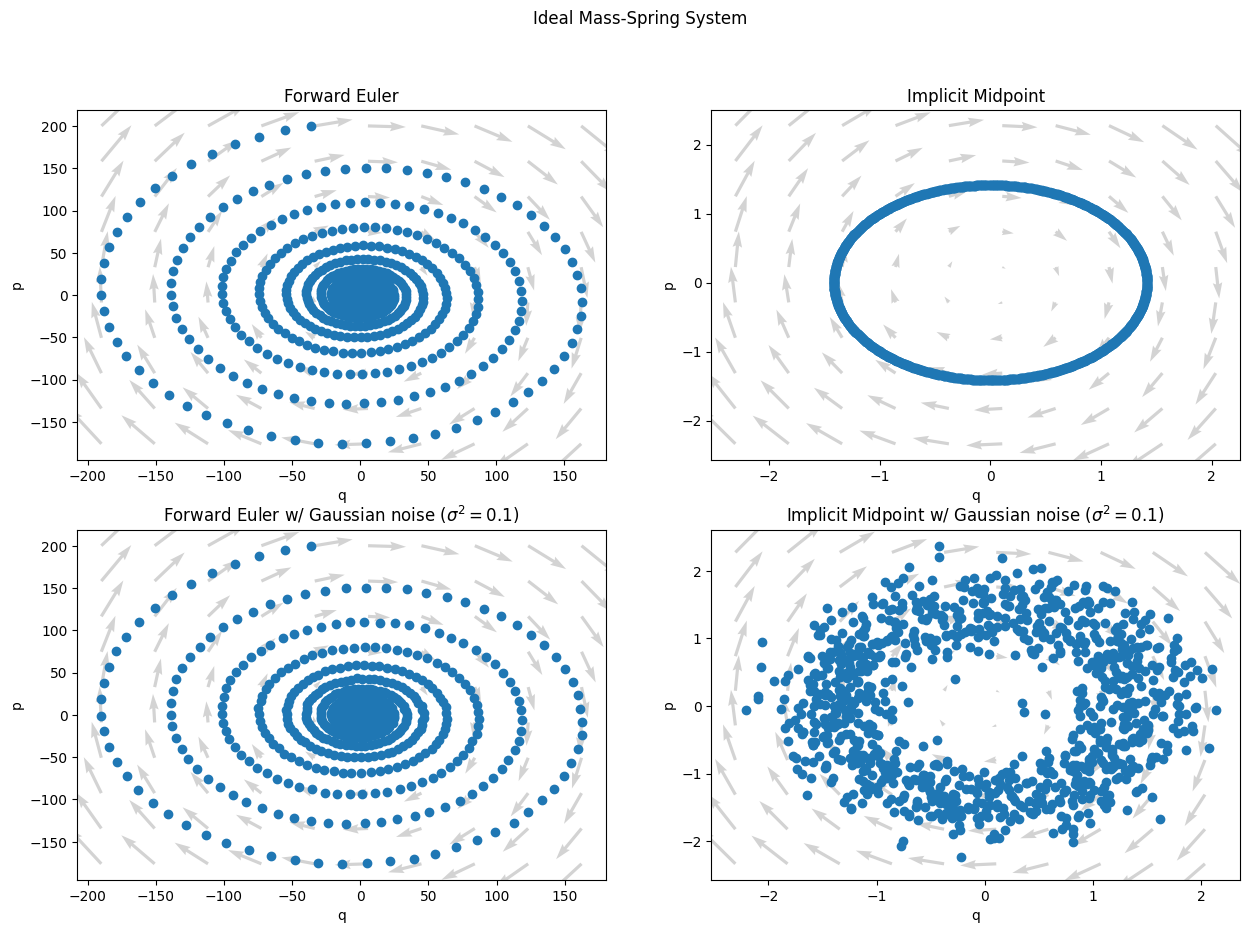

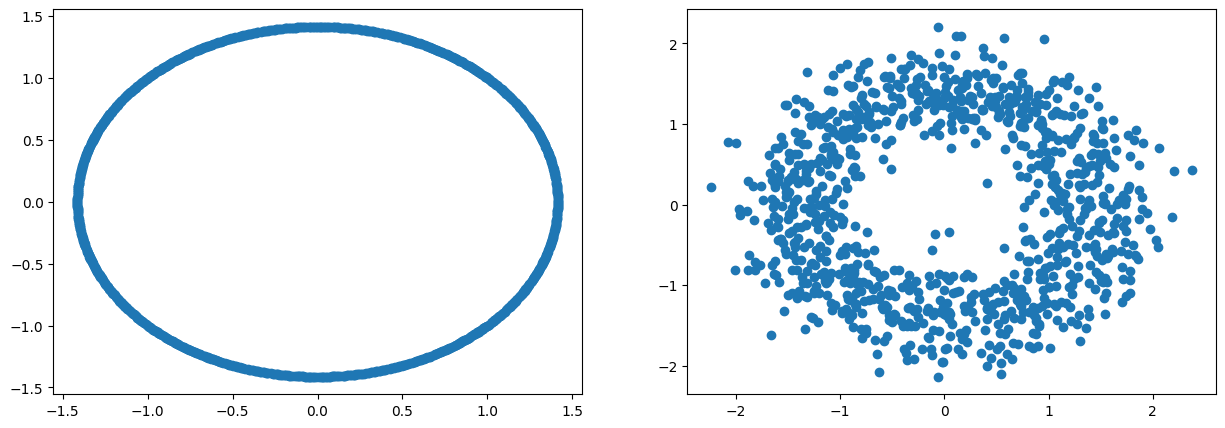

In [4]:
# Initial point
x0 = np.array([1, 1])

# Step size
h = 0.1

# Number of points to sample
n_points = 1000

# Array to store all values
x_forwardeuler_arr = np.empty((n_points, 2))
x_midpoint_arr = np.empty((n_points, 2))
x_forwardeuler_arr[0] = x0
x_midpoint_arr[0] = x0

# Find next step
for i in range(1, n_points):
    x_forwardeuler_arr[i] = forwardEuler(f=f, x0=x_forwardeuler_arr[i - 1], h=h)
for i in range(1, n_points):
    x_midpoint_arr[i] = implicitMidpoint(f=f, Jf=gradf, x0=x_midpoint_arr[i - 1], h=h)

# Add guassian noise with sigma^2=0.1
x_forwardeuler_noise_arr = gaussian_noise(x_forwardeuler_arr, mu=0.0, std=np.sqrt(0.1))
x_midpoint_noise_arr = gaussian_noise(x_midpoint_arr, mu=0.0, std=np.sqrt(0.1))

# Plot iterative result with and without noise
forward_euler = [x_forwardeuler_arr, x_forwardeuler_noise_arr]
implicit_midpoint = [x_midpoint_arr, x_midpoint_noise_arr]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, (point_arr, title) in enumerate(
    zip([forward_euler, implicit_midpoint], ["Forward Euler", "Implicit Midpoint"])
):
    # Vector field of Hamiltonian (with noise boundary)
    x_min = point_arr[1][:, 0].min() - 0.1
    x_max = point_arr[1][:, 0].max() - 0.1
    y_min = point_arr[1][:, 1].min() - 0.1
    y_max = point_arr[1][:, 1].max() - 0.1
    # Meshgrid
    x, y = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    # Directional vectors
    deriv = f([x, y])
    u, v = deriv[0, :, :], deriv[1, :, :]

    axs[0][i].plot(point_arr[0][:, 0], point_arr[0][:, 1], "o")
    axs[0][i].set_xlabel("q")
    axs[0][i].set_ylabel("p")
    axs[0][i].set_title(title)
    axs[0][i].quiver(x, y, u, v, color="lightgrey")  # Plotting Vector Field with QUIVER
    axs[1][i].plot(point_arr[1][:, 0], point_arr[1][:, 1], "o")
    axs[1][i].set_xlabel("q")
    axs[1][i].set_ylabel("p")
    axs[1][i].set_title(f"{title} w/ Gaussian noise ($\sigma^2 = 0.1$)")
    axs[1][i].quiver(x, y, u, v, color="lightgrey")  # Plotting Vector Field with QUIVER
plt.suptitle("Ideal Mass-Spring System")
plt.show()

# Create dataset of MidpointMethod:
X_clean = x_midpoint_arr.copy()
X_noise = x_midpoint_noise_arr.copy()

# Compute derivative (correct labels)
y_clean = np.array([x_midpoint_arr[:, 1] / m, -k * x_midpoint_arr[:, 0]]).T

y_noise = np.array([x_midpoint_noise_arr[:, 1] / m, -k * x_midpoint_noise_arr[:, 0]]).T

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(y_clean[:, 0], y_clean[:, 1], "o")
axs[1].plot(y_noise[:, 0], y_noise[:, 1], "o")
plt.show()

### Train-test split

Shape of synthetic dataset (X, y): (torch.Size([1000, 2]), torch.Size([1000, 2]))


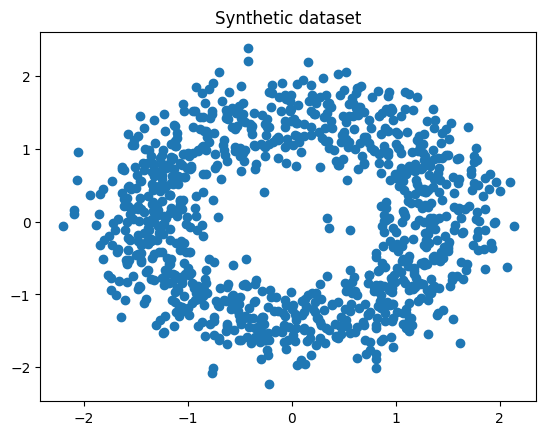

/Users/martineh/Library/Caches/pypoetry/virtualenvs/harmonic-o-0uXIVf-py3.9/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


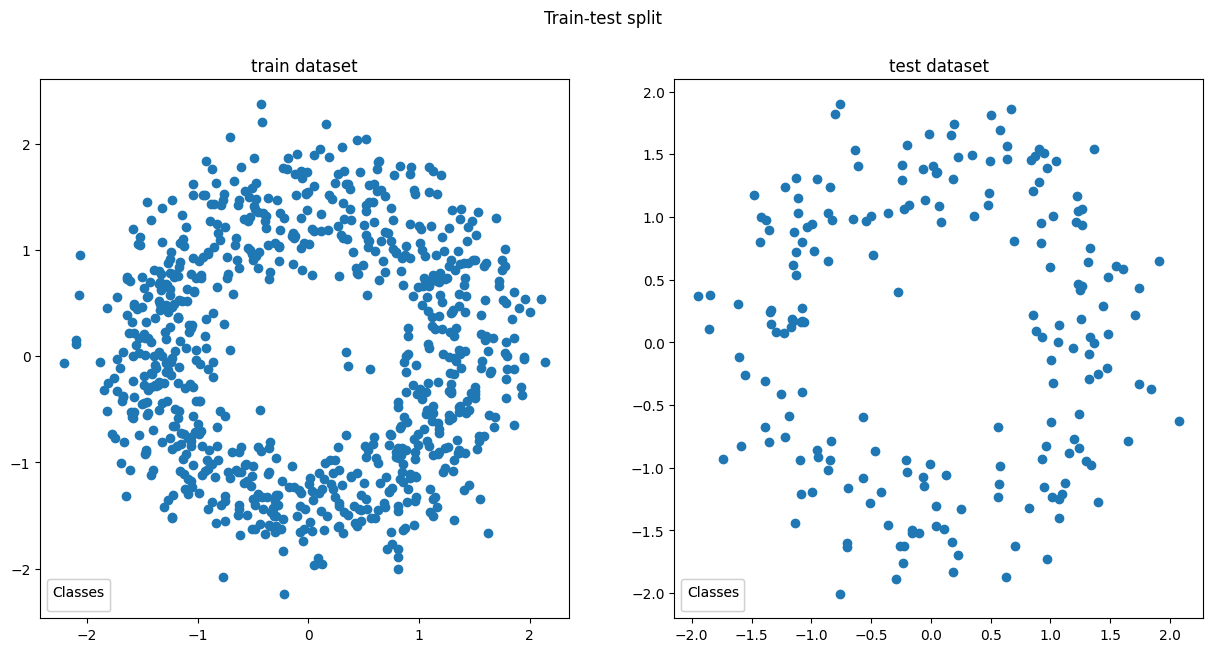

In [5]:
X = X_noise
y = y_clean

(
    train_dataloader,
    test_dataloader,
    train_data,
    test_data,
    X_train,
    y_train,
    X_test,
    y_test,
) = get_dataloader_from_numpy_dataset(X=X, y=y, BATCH_SIZE=len(X), X_requires_grad=True)

### Initialize model

In [53]:
# Initialize model
n_hidden_layers = 3  # 1 - 3 layers in total (1 input, 1 output, 1 hidden)
n_hidden_units = 200
n_input_units = 2
n_output_units_baseline = 2
n_output_units_hnn = 1


torch.manual_seed(42)  # set seed for random parameters in model
baseline_model = BaselineModel(
    input_dim=n_input_units,
    hidden_dim=n_hidden_layers,
    output_dim=n_output_units_baseline,
    n_hidden_layers=n_hidden_layers,
)

# Select optimizer and loss function
baseline_loss_fn = nn.MSELoss()

# Create an optimizer
baseline_optimizer = torch.optim.Adam(
    params=baseline_model.parameters(), lr=1e-3, weight_decay=1e-4
)

accuracy_fn = MeanSquaredError()

Hnn Network?

In [54]:
hnn_model = HnnModel(
    input_dim=n_input_units,
    hidden_dim=n_hidden_layers,
    output_dim=n_output_units_hnn,
    n_hidden_layers=n_hidden_layers,
)

# Select optimizer and loss function
hnn_loss_fn = nn.MSELoss()

# Create an optimizer
hnn_optimizer = torch.optim.Adam(
    params=hnn_model.parameters(), lr=1e-3, weight_decay=1e-4
)

## Train and Evaluate Baseline Model

In [55]:
# Train and test for multiple epochs
epochs = 2000
train_loss_per_epoch = []
test_loss_per_epoch = []
train_acc_per_epoch = []
test_acc_per_epoch = []

for epoch in range(epochs):
    print(f"----> EPOCH {epoch} of {epochs}:")
    train_loss, train_acc = train_model(
        model=baseline_model,
        data_loader=train_dataloader,
        loss_fn=baseline_loss_fn,
        optimizer=baseline_optimizer,
        accuracy_fn=accuracy_fn,
        verbose=False,
    )

    test_loss, test_acc = test_model(
        model=baseline_model,
        data_loader=test_dataloader,
        loss_fn=baseline_loss_fn,
        accuracy_fn=accuracy_fn,
    )

    train_loss_per_epoch.append(train_loss.detach().numpy())
    train_acc_per_epoch.append(train_acc)

    test_loss_per_epoch.append(test_loss.detach().numpy())
    test_acc_per_epoch.append(test_acc)

----> EPOCH 0 of 2000:
Train loss: 1.13211 | Train accuracy (MeanSquaredError()): 1.13%
Test loss: 1.17080 | Test accuracy (MeanSquaredError()): 1.17%

----> EPOCH 1 of 2000:
Train loss: 1.13025 | Train accuracy (MeanSquaredError()): 1.13%
Test loss: 1.16872 | Test accuracy (MeanSquaredError()): 1.17%

----> EPOCH 2 of 2000:
Train loss: 1.12841 | Train accuracy (MeanSquaredError()): 1.13%
Test loss: 1.16666 | Test accuracy (MeanSquaredError()): 1.17%

----> EPOCH 3 of 2000:
Train loss: 1.12658 | Train accuracy (MeanSquaredError()): 1.13%
Test loss: 1.16463 | Test accuracy (MeanSquaredError()): 1.16%

----> EPOCH 4 of 2000:
Train loss: 1.12479 | Train accuracy (MeanSquaredError()): 1.12%
Test loss: 1.16262 | Test accuracy (MeanSquaredError()): 1.16%

----> EPOCH 5 of 2000:
Train loss: 1.12301 | Train accuracy (MeanSquaredError()): 1.12%
Test loss: 1.16063 | Test accuracy (MeanSquaredError()): 1.16%

----> EPOCH 6 of 2000:
Train loss: 1.12126 | Train accuracy (MeanSquaredError()): 1.12%


/var/folders/j7/jprhc52j189bk1mlz017z20h0000gn/T/ipykernel_89389/4222816279.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)


Test loss: 1.12285 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 28 of 2000:
Train loss: 1.08821 | Train accuracy (MeanSquaredError()): 1.09%
Test loss: 1.12138 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 29 of 2000:
Train loss: 1.08692 | Train accuracy (MeanSquaredError()): 1.09%
Test loss: 1.11992 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 30 of 2000:
Train loss: 1.08566 | Train accuracy (MeanSquaredError()): 1.09%
Test loss: 1.11849 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 31 of 2000:
Train loss: 1.08441 | Train accuracy (MeanSquaredError()): 1.08%
Test loss: 1.11706 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 32 of 2000:
Train loss: 1.08317 | Train accuracy (MeanSquaredError()): 1.08%
Test loss: 1.11566 | Test accuracy (MeanSquaredError()): 1.12%

----> EPOCH 33 of 2000:
Train loss: 1.08195 | Train accuracy (MeanSquaredError()): 1.08%
Test loss: 1.11427 | Test accuracy (MeanSquaredError()): 1.11%

----> EPOCH 34 of 

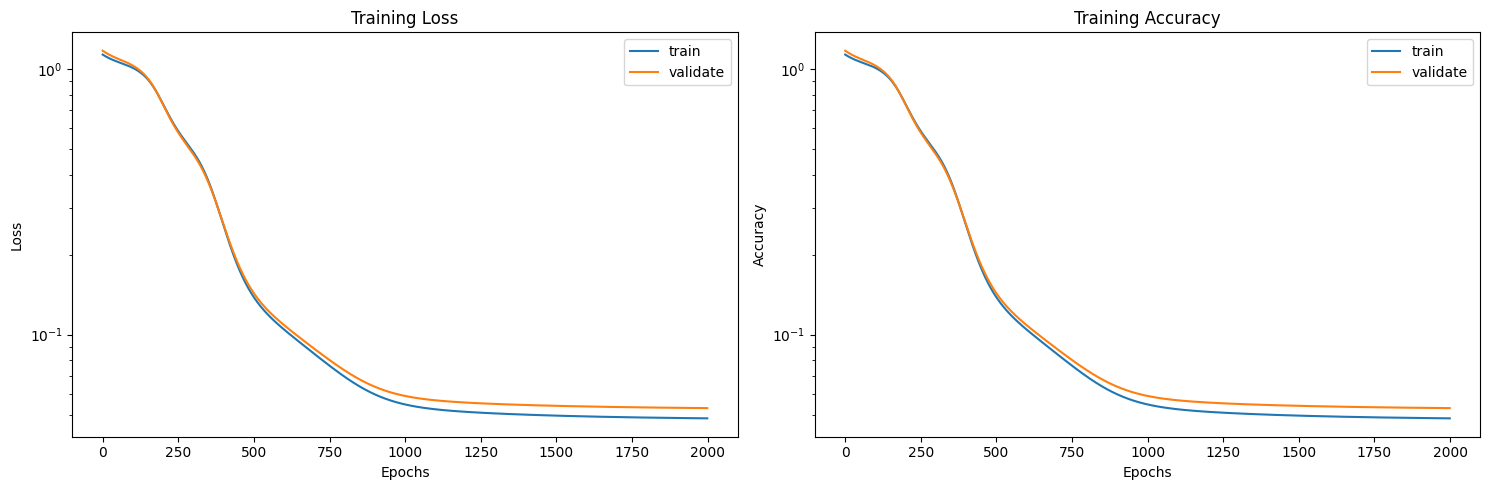

In [56]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_per_epoch, label="train")
axs[0].plot(test_loss_per_epoch, label="validate")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(train_acc_per_epoch, label="train")
axs[1].plot(test_acc_per_epoch, label="validate")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")
axs[1].set_yscale("log")
axs[1].legend()

plt.tight_layout()
plt.show()

MSE: 0.05291277915239334
Test metrics: {'model_name': 'BaselineModel', 'model_loss': 0.05291277915239334, 'model_acc': 0.05291277915239334}


/var/folders/j7/jprhc52j189bk1mlz017z20h0000gn/T/ipykernel_89389/4222816279.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)


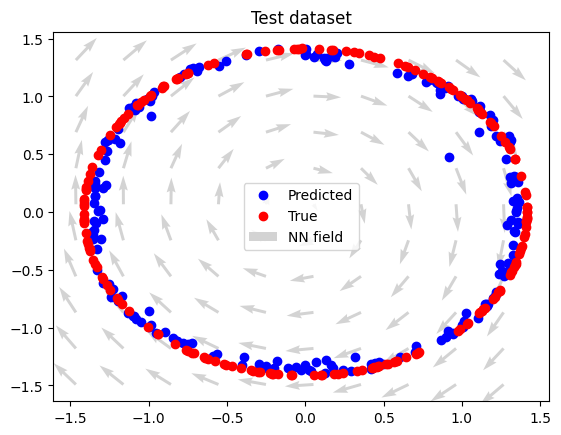

In [57]:
# Metrics
mean_squared_error = MeanSquaredError()
print(f"MSE: {mean_squared_error(baseline_model(X_test), y_test)}")

# Test metrics
test_metrics, y_preds = test_model(
    model=baseline_model,
    data_loader=test_dataloader,
    loss_fn=baseline_loss_fn,
    accuracy_fn=accuracy_fn,
    evaluate=True,  # get final result(evaluate=True)
)
y_pred = y_preds.reshape((y_preds.shape[1], y_preds.shape[2]))

print(f"Test metrics: {test_metrics}")

## Vector field of learned network
x_min, x_max = y_pred[:, 0].min() - 0.1, y_pred[:, 0].max() - 0.1
y_min, y_max = y_pred[:, 1].min() - 0.1, y_pred[:, 1].max() - 0.1
xx, yy = np.meshgrid(  # meshgrid
    np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10)
)
X_meshgrid = torch.from_numpy(  # make points
    np.column_stack((xx.ravel(), yy.ravel()))
).float()
baseline_model.eval()  # Make predictions on grid
# with torch.inference_mode():
field_raw = baseline_model(X_meshgrid)
field_pred = baseline_model.postprocess(field_raw, X_meshgrid)
field_pred = (
    field_pred.reshape((xx.shape[0], xx.shape[1], 2)).detach().numpy()
)  # Reshape to 2D
u, v = field_pred[:, :, 0], field_pred[:, :, 1]  # directional vectors

# Plot
plt.plot(y_pred[:, 0], y_pred[:, 1], "o", c="blue", label="Predicted")
plt.plot(y_test[:, 0], y_test[:, 1], "o", c="red", label="True")
plt.quiver(
    xx, yy, u, v, color="lightgrey", label="NN field"
)  # Plotting Vector Field with QUIVER
plt.title("Test dataset")
plt.legend()
plt.show()

### Find vector field of trained network, and integrate a trajectory in this vector field 

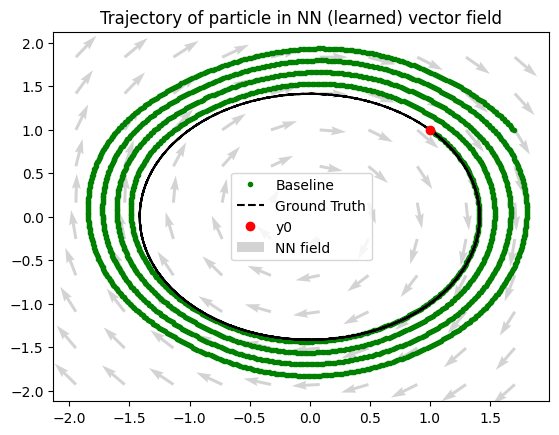

In [58]:
def baseline_field(t, x):
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=0)  # to tensor
    dx = baseline_model(x).detach().numpy()
    return dx


def true_field(t, x):
    q, p = np.split(x, 2)
    dqdt = p / m
    dpdt = -k * q
    S = np.concatenate([dqdt, dpdt], axis=-1)
    return S


# Integrate along those fields starting from point (1,0)
t_span = [0, 30]
y0 = np.asarray([1.0, 1])
kwargs = {
    "t_eval": np.linspace(t_span[0], t_span[1], 2000),
    "rtol": 1e-12,
}  # TODO: Hva gjør denne kwargsen?

sol_baseline = scipy.integrate.solve_ivp(
    fun=baseline_field, t_span=t_span, y0=y0, **kwargs
)
sol_true = scipy.integrate.solve_ivp(fun=true_field, t_span=t_span, y0=y0, **kwargs)

## Vector field of learned network
x_min, x_max = (
    min(sol_baseline.y[0, :].min(), sol_true.y[0, :].min()) - 0.1,
    max(sol_baseline.y[0, :].max(), sol_true.y[0, :].max()) - 0.1,
)
y_min, y_max = (
    min(sol_baseline.y[1, :].min(), sol_true.y[1, :].min()) - 0.1,
    max(sol_baseline.y[1, :].max(), sol_true.y[1, :].max()) - 0.1,
)
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10)
)  # meshgrid
X_meshgrid = torch.from_numpy(
    np.column_stack((xx.ravel(), yy.ravel()))
).float()  # make points
baseline_model.eval()  # Make predictions on grid
# with torch.inference_mode():
field_raw = baseline_model(X_meshgrid)
field_pred = baseline_model.postprocess(field_raw, X_meshgrid)
field_pred = (
    field_pred.reshape((xx.shape[0], xx.shape[1], 2)).detach().numpy()
)  # Reshape to 2D
u, v = field_pred[:, :, 0], field_pred[:, :, 1]  # directional vectors

# Plot
plt.plot(sol_baseline.y[0, :], sol_baseline.y[1, :], ".", c="green", label="Baseline")
plt.plot(sol_true.y[0, :], sol_true.y[1, :], "--", c="black", label="Ground Truth")
plt.plot(y0[0], y0[1], "o", c="red", label="y0")
plt.quiver(
    xx, yy, u, v, color="lightgrey", label="NN field"
)  # Plotting Vector Field with QUIVER
plt.title("Trajectory of particle in NN (learned) vector field")
plt.legend()
plt.show()

In [59]:
## TODO: Plot energy/conserved quantity

## TODO: Plot MSE between points (compared to Grouod truth)

## Train and evaluate HNN network

In [60]:
# Train and test for multiple epochs
epochs = 2000
train_loss_per_epoch = []
test_loss_per_epoch = []
train_acc_per_epoch = []
test_acc_per_epoch = []

for epoch in range(epochs):
    print(f"----> EPOCH {epoch} of {epochs}:")
    train_loss, train_acc = train_model(
        model=hnn_model,
        data_loader=train_dataloader,
        loss_fn=hnn_loss_fn,
        optimizer=hnn_optimizer,
        accuracy_fn=accuracy_fn,
        verbose=False,
        grad=True,
    )

    test_loss, test_acc = test_model(
        model=hnn_model,
        data_loader=test_dataloader,
        loss_fn=hnn_loss_fn,
        accuracy_fn=accuracy_fn,
        grad=True,
    )

    train_loss_per_epoch.append(train_loss.detach().numpy())
    train_acc_per_epoch.append(train_acc)

    test_loss_per_epoch.append(test_loss.detach().numpy())
    test_acc_per_epoch.append(test_acc)

----> EPOCH 0 of 2000:
Train loss: 0.99723 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99687 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 1 of 2000:
Train loss: 0.99699 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99662 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 2 of 2000:
Train loss: 0.99675 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99637 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 3 of 2000:
Train loss: 0.99651 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99611 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 4 of 2000:
Train loss: 0.99627 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99586 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 5 of 2000:
Train loss: 0.99602 | Train accuracy (MeanSquaredError()): 1.00%
Test loss: 0.99560 | Test accuracy (MeanSquaredError()): 1.00%

----> EPOCH 6 of 2000:
Train loss: 0.99578 | Train accuracy (MeanSquaredError()): 1.00%


/var/folders/j7/jprhc52j189bk1mlz017z20h0000gn/T/ipykernel_89389/4222816279.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)


Train loss: 0.99396 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99343 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 14 of 2000:
Train loss: 0.99369 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99315 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 15 of 2000:
Train loss: 0.99342 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99286 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 16 of 2000:
Train loss: 0.99314 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99256 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 17 of 2000:
Train loss: 0.99285 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99227 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 18 of 2000:
Train loss: 0.99256 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.99196 | Test accuracy (MeanSquaredError()): 0.99%

----> EPOCH 19 of 2000:
Train loss: 0.99227 | Train accuracy (MeanSquaredError()): 0.99%
Test loss: 0.9916

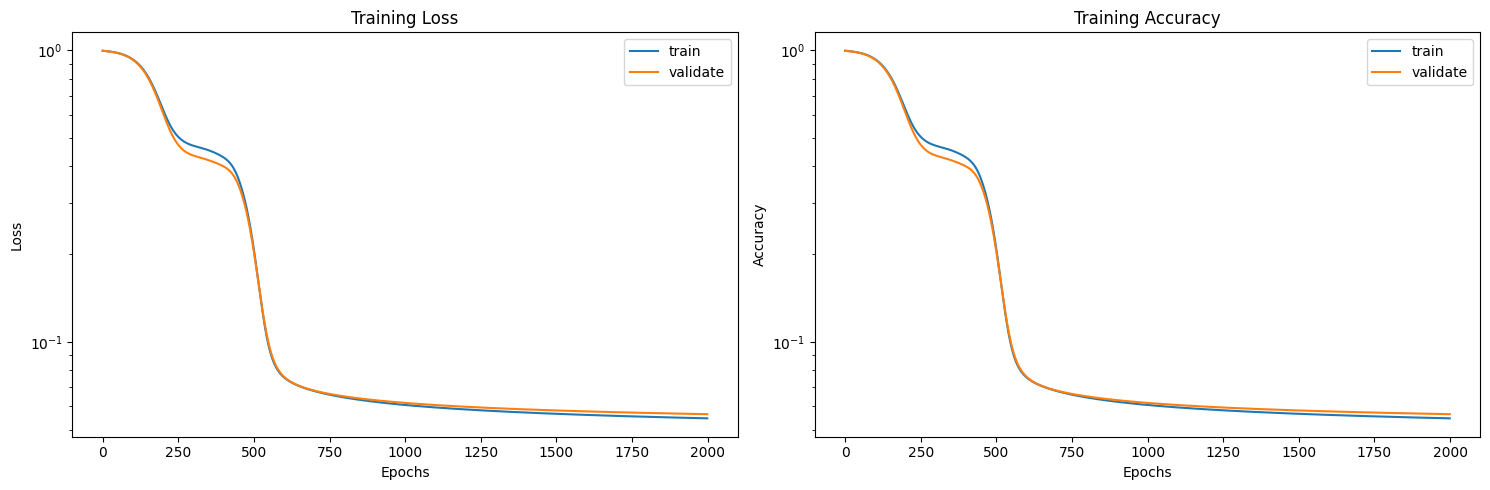

In [61]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_loss_per_epoch, label="train")
axs[0].plot(test_loss_per_epoch, label="validate")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(train_acc_per_epoch, label="train")
axs[1].plot(test_acc_per_epoch, label="validate")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")
axs[1].set_yscale("log")
axs[1].legend()

plt.tight_layout()
plt.show()

MSE: 0.05645120516419411
Test metrics: {'model_name': 'HnnModel', 'model_loss': 0.05645120516419411, 'model_acc': 0.05645120516419411}


/var/folders/j7/jprhc52j189bk1mlz017z20h0000gn/T/ipykernel_89389/4222816279.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True, dtype=torch.float32)


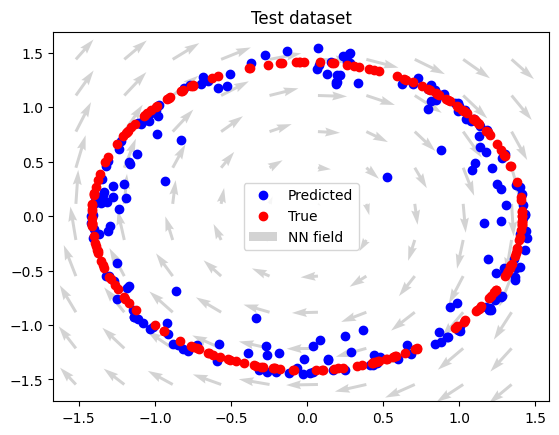

In [62]:
# Metrics
mean_squared_error = MeanSquaredError()
print(
    f"MSE: {mean_squared_error(hnn_model.postprocess(y=hnn_model(X_test), x= X_test), y_test)}"
)

# Test metrics
test_metrics, y_preds = test_model(
    model=hnn_model,
    data_loader=test_dataloader,
    loss_fn=hnn_loss_fn,
    accuracy_fn=accuracy_fn,
    evaluate=True,  # get final result(evaluate=True)
    grad=True,
)
y_pred = y_preds.reshape((y_preds.shape[1], y_preds.shape[2]))

print(f"Test metrics: {test_metrics}")

## Vector field of learned network
x_min, x_max = y_pred[:, 0].min() - 0.1, y_pred[:, 0].max() - 0.1
y_min, y_max = y_pred[:, 1].min() - 0.1, y_pred[:, 1].max() - 0.1
xx, yy = np.meshgrid(  # meshgrid
    np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10)
)
X_meshgrid = torch.tensor(
    np.column_stack((xx.ravel(), yy.ravel())), requires_grad=True, dtype=torch.float32
)  # make points
hnn_model.eval()  # Make predictions on grid
# with torch.inference_mode():
field_raw = hnn_model(X_meshgrid)
field_pred = hnn_model.postprocess(field_raw, X_meshgrid)


field_pred = (
    field_pred.reshape((xx.shape[0], xx.shape[1], 2)).detach().numpy()
)  # Reshape to 2D
u, v = field_pred[:, :, 0], field_pred[:, :, 1]  # directional vectors

# Plot
plt.plot(y_pred[:, 0], y_pred[:, 1], "o", c="blue", label="Predicted")
plt.plot(y_test[:, 0], y_test[:, 1], "o", c="red", label="True")
plt.quiver(
    xx, yy, u, v, color="lightgrey", label="NN field"
)  # Plotting Vector Field with QUIVER
plt.title("Test dataset")
plt.legend()
plt.show()

### Find vector field of trained network, and integrate a trajectory in this vector field 

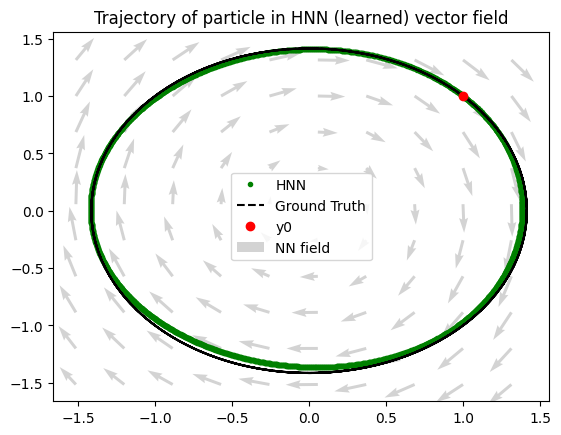

In [63]:
def hnn_field(t, x):
    x = torch.tensor(x, requires_grad=True, dtype=torch.float32)

    if len(x.shape) == 1:
        x = x.unsqueeze(dim=0)  # to tensor
    dx_raw = hnn_model(x)
    dx_pred = hnn_model.postprocess(dx_raw, x)
    return dx_pred.detach().numpy()


def true_field(t, x):
    q, p = np.split(x, 2)
    dqdt = p / m
    dpdt = -k * q
    S = np.concatenate([dqdt, dpdt], axis=-1)
    return S


# Integrate along those fields starting from point (1,0)
t_span = [0, 30]
y0 = np.asarray([1.0, 1])
kwargs = {
    "t_eval": np.linspace(t_span[0], t_span[1], 2000),
    "rtol": 1e-12,
}  # TODO: Hva gjør denne kwargsen?

sol_hnn = scipy.integrate.solve_ivp(fun=hnn_field, t_span=t_span, y0=y0, **kwargs)
sol_true = scipy.integrate.solve_ivp(fun=true_field, t_span=t_span, y0=y0, **kwargs)

## Vector field of learned network
x_min, x_max = (
    min(sol_true.y[0, :].min(), sol_true.y[0, :].min()) - 0.1,
    max(sol_true.y[0, :].max(), sol_true.y[0, :].max()) - 0.1,
)
y_min, y_max = (
    min(sol_true.y[1, :].min(), sol_true.y[1, :].min()) - 0.1,
    max(sol_true.y[1, :].max(), sol_true.y[1, :].max()) - 0.1,
)
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10)
)  # meshgrid
X_meshgrid = torch.tensor(
    np.column_stack((xx.ravel(), yy.ravel())), requires_grad=True, dtype=torch.float32
)  # make points
hnn_model.eval()  # Make predictions on grid
# with torch.inference_mode():
field_raw = hnn_model(X_meshgrid)
field_pred = hnn_model.postprocess(field_raw, X_meshgrid)

field_pred = (
    field_pred.reshape((xx.shape[0], xx.shape[1], 2)).detach().numpy()
)  # Reshape to 2D
u, v = field_pred[:, :, 0], field_pred[:, :, 1]  # directional vectors

# Plot
plt.plot(sol_hnn.y[0, :], sol_hnn.y[1, :], ".", c="green", label="HNN")
plt.plot(sol_true.y[0, :], sol_true.y[1, :], "--", c="black", label="Ground Truth")
plt.plot(y0[0], y0[1], "o", c="red", label="y0")
plt.quiver(
    xx, yy, u, v, color="lightgrey", label="NN field"
)  # Plotting Vector Field with QUIVER
plt.title("Trajectory of particle in HNN (learned) vector field")
plt.legend()
plt.show()

In [64]:
## TODO: Plot energy/conserved quantity

## TODO: Plot MSE between points (compared to Grouod truth)

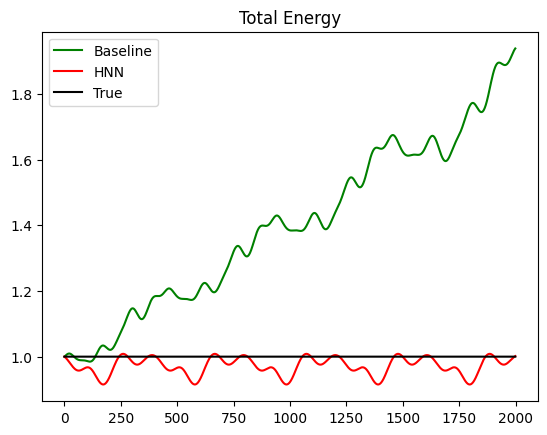

In [65]:
def compute_energy(q, p):
    return 1 / 2 * k * q**2 + p**2 / (2 * m)


q_baseline, p_baseline = sol_baseline.y[0, :], sol_baseline.y[1, :]
E_baseline = compute_energy(q_baseline, p_baseline)

q_hnn, p_hnn = sol_hnn.y[0, :], sol_hnn.y[1, :]
E_hnn = compute_energy(q_hnn, p_hnn)

q_true, p_true = sol_true.y[0, :], sol_true.y[1, :]
E_true = compute_energy(q_true, p_true)

plt.plot(E_baseline, c="green", label="Baseline")
plt.plot(E_hnn, c="red", label="HNN")
plt.plot(E_true, c="black", label="True")
plt.legend()
plt.title("Total Energy")
plt.show()

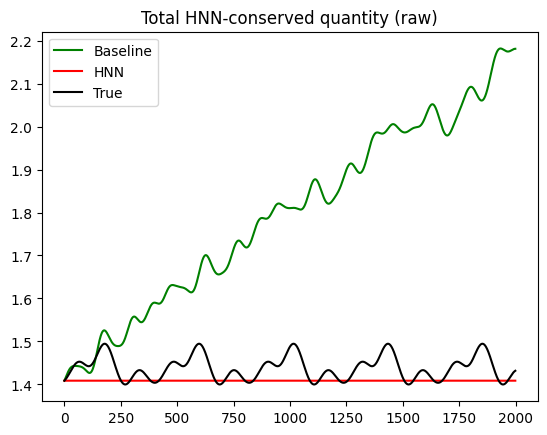

In [67]:
y_baseline_tensor = torch.tensor(
    sol_baseline.y.T, requires_grad=True, dtype=torch.float32
)
y_hnn_tensor = torch.tensor(sol_hnn.y.T, requires_grad=True, dtype=torch.float32)
y_true_tensor = torch.tensor(sol_true.y.T, requires_grad=True, dtype=torch.float32)

hnn_conserved_raw_baseline = hnn_model(y_baseline_tensor).detach().numpy()
hnn_conserved_raw_hnn = hnn_model(y_hnn_tensor).detach().numpy()
hnn_conserved_raw_true = hnn_model(y_true_tensor).detach().numpy()


plt.plot(hnn_conserved_raw_baseline, c="green", label="Baseline")
plt.plot(hnn_conserved_raw_hnn, c="red", label="HNN")
plt.plot(hnn_conserved_raw_true, c="black", label="True")
plt.legend()
plt.title("Total HNN-conserved quantity (raw)")
plt.show()